In [1]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
!pip install -q torch==1.10.0
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu102.html    

---

### PyTorch Geometric

In [4]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

In [5]:
class GCNConvNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(GCNConvNet, self).__init__()
        self.gcn_0 = GCNConv(in_channels, 64)
        self.gcn_h1 = GCNConv(64, 64)
        self.gcn_h2 = GCNConv(64, 64)
        self.gcn_h3 = GCNConv(64, 64)
        self.gcn_h4 = GCNConv(64, 64)
        self.gcn_h5 = GCNConv(64, 64)
        self.gcn_h6 = GCNConv(64, 64)
        self.gcn_out = GCNConv(64, out_channels)
        
    def forward(self, batch):
        x, edge_index, batch_graph = batch.x, batch.edge_index, batch.batch
        x = torch.relu(self.gcn_0(x, edge_index))
        x = torch.relu(self.gcn_h1(x, edge_index))
        x = torch.relu(self.gcn_h2(x, edge_index))
        x = torch.relu(self.gcn_h3(x, edge_index))
        x = torch.relu(self.gcn_h4(x, edge_index))
        x = torch.relu(self.gcn_h5(x, edge_index))
        x = torch.relu(self.gcn_h6(x, edge_index))
        x = torch.dropout(x, p=0.25, train=self.training)
        x = self.gcn_out(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [18]:
dataset = PPI(root="./tmp")
dataset = dataset.shuffle()

Extracting tmp/ppi.zip
Processing...
Done!


In [19]:
test_dataset = dataset[:2]
train_dataset = dataset[2:]
test_loader = DataLoader(test_dataset, batch_size=1)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [23]:
for batch in train_loader: break

In [29]:
print(batch)
in_channels = batch.x.shape[1]
out_channels = dataset.num_classes
print(f"in_channels: {in_channels}")
print(f"out_channels: {out_channels}")

DataBatch(x=[19310, 50], edge_index=[2, 550228], y=[19310, 121], batch=[19310], ptr=[9])
in_channels: 50
out_channels: 121


In [104]:
g_conv = GCNConv(in_channels=50, out_channels=2)
print(batch.x.shape)
print(g_conv(x=batch.x.to('cpu'), edge_index=batch.edge_index.to('cpu')).shape)

torch.Size([5299, 50])
torch.Size([5299, 2])


In [48]:
num_epochs = 10000
lr = 1e-3
model = GCNConvNet(
    in_channels=in_channels,
    out_channels=out_channels
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
my_device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(my_device)

In [49]:
losses = []
time_elapsed = []
epochs = []
t0 = time.time()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    batch_count = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch.to(my_device))
        loss = loss_fn(pred, batch.y.to(my_device))
        loss.backward()
        optimizer.step()
        total_loss += loss.detach()
        batch_count += 1
    mean_loss = total_loss / batch_count
    losses.append(mean_loss)
    epochs.append(epoch)
    time_elapsed.append(time.time()-t0)
    if epoch % 100 == 0:
        print(f"loss at epoch {epoch} = {mean_loss}")

  0%|          | 0/10000 [00:00<?, ?it/s]

loss at epoch 0 = 0.6925579309463501
loss at epoch 100 = 0.5686668157577515
loss at epoch 200 = 0.5485591888427734
loss at epoch 300 = 0.539613664150238
loss at epoch 400 = 0.5237611532211304
loss at epoch 500 = 0.5162431597709656
loss at epoch 600 = 0.5110690593719482
loss at epoch 700 = 0.5058647990226746
loss at epoch 800 = 0.500960648059845
loss at epoch 900 = 0.5056134462356567
loss at epoch 1000 = 0.5054253935813904
loss at epoch 1100 = 0.4940776824951172
loss at epoch 1200 = 0.4920627772808075
loss at epoch 1300 = 0.4901476800441742
loss at epoch 1400 = 0.4874822497367859
loss at epoch 1500 = 0.4885723292827606
loss at epoch 1600 = 0.49146318435668945
loss at epoch 1700 = 0.48337334394454956
loss at epoch 1800 = 0.4878213405609131
loss at epoch 1900 = 0.48189136385917664
loss at epoch 2000 = 0.47994086146354675
loss at epoch 2100 = 0.48531636595726013
loss at epoch 2200 = 0.4841183125972748
loss at epoch 2300 = 0.48853135108947754
loss at epoch 2400 = 0.4773240089416504
loss at 

KeyboardInterrupt: 

In [55]:
losses_cpu = [val.cpu().item() for val in losses]

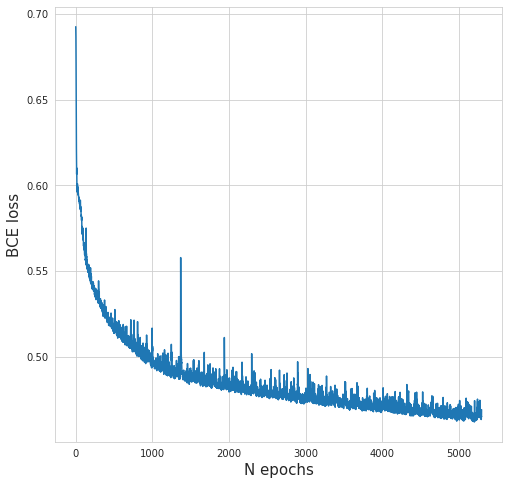

In [57]:
plt.plot(epochs, losses_cpu);
plt.xlabel('N epochs', fontsize=15)
plt.ylabel('BCE loss', fontsize=15);

In [58]:
model.to('cpu')

GCNConvNet(
  (gcn_0): GCNConv(50, 64)
  (gcn_h1): GCNConv(64, 64)
  (gcn_h2): GCNConv(64, 64)
  (gcn_h3): GCNConv(64, 64)
  (gcn_h4): GCNConv(64, 64)
  (gcn_h5): GCNConv(64, 64)
  (gcn_h6): GCNConv(64, 64)
  (gcn_out): GCNConv(64, 121)
)

In [59]:
for test_batch in test_loader: break

In [78]:
y_test_all_true = []
y_test_all_pred = []
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        res = model(test_batch)
        y_test_all_pred.extend(list(res.ravel().numpy()))
        y_test_all_true.extend(list(test_batch.y.ravel().numpy()))

  0%|          | 0/2 [00:00<?, ?it/s]

In [73]:
from sklearn import metrics

In [82]:
metrics.accuracy_score(
    y_true=y_test_all_true,
    y_pred=(np.array(y_test_all_pred) > 0.5).astype(int)
)

0.6834479422959645

In [83]:
metrics.roc_auc_score(
    y_true=y_test_all_true,
    y_score=np.array(y_test_all_pred)
)

0.6725790828166789

In [84]:
# Проверим качество на сети с рандомной инициализацией весов
model_random = GCNConvNet(
    in_channels=in_channels,
    out_channels=out_channels
)

In [85]:
y_test_all_true = []
y_test_all_pred = []
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        res = model_random(test_batch)
        y_test_all_pred.extend(list(res.ravel().numpy()))
        y_test_all_true.extend(list(test_batch.y.ravel().numpy()))

  0%|          | 0/2 [00:00<?, ?it/s]

In [86]:
metrics.accuracy_score(
    y_true=y_test_all_true,
    y_pred=(np.array(y_test_all_pred) > 0.5).astype(int)
)

0.522209429478687

In [87]:
metrics.roc_auc_score(
    y_true=y_test_all_true,
    y_score=np.array(y_test_all_pred)
)

0.5006005654516015

### DGL

In [6]:
# !pip install dgl-cu102 -f https://data.dgl.ai/wheels/repo.html
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import dgl
print(dgl.__version__)

Using backend: pytorch


0.6.1


In [8]:
import time
import numpy as np
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
from dgl.data import PPIDataset
from dgl.dataloading.pytorch import GraphDataLoader
from dgl.data.utils import split_dataset

In [16]:
class GraphConvNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(GraphConvNet, self).__init__()
        self.gcn_0 = GraphConv(in_channels, 64, allow_zero_in_degree=True)
        self.gcn_h1 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_h2 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_h3 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_h4 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_h5 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_h6 = GraphConv(64, 64, allow_zero_in_degree=True)
        self.gcn_out = GraphConv(64, out_channels, allow_zero_in_degree=True)
    def forward(self, g, features):
        x = torch.relu(self.gcn_0(g, features))
        x = torch.relu(self.gcn_h1(g, x))
        x = torch.relu(self.gcn_h2(g, x))
        x = torch.relu(self.gcn_h3(g, x))
        x = torch.relu(self.gcn_h4(g, x))
        x = torch.relu(self.gcn_h5(g, x))
        x = torch.relu(self.gcn_h6(g, x))
        x = torch.dropout(x, p=0.25, train=self.training)
        x = self.gcn_out(g, x)
        x = torch.sigmoid(x)
        return x

In [11]:
dataset = PPIDataset()
test_dataset, train_dataset = split_dataset(dataset, [0.1, 0.9], shuffle=True)
train_loader = GraphDataLoader(train_dataset, batch_size=8)
test_loader = GraphDataLoader(test_dataset, batch_size=1)

In [12]:
for batch in train_loader: break

In [15]:
print(batch)
in_channels = batch.ndata["feat"].shape[1]
out_channels = dataset.num_labels
print(f"in_channels: {in_channels}")
print(f"out_channels: {out_channels}")

Graph(num_nodes=17589, num_edges=507823,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(50,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
in_channels: 50
out_channels: 121


In [23]:
model_dgl = GraphConvNet(in_channels, out_channels)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_dgl.parameters(), lr=1e-3)
# my_device = "cuda" if torch.cuda.is_available() else "cpu"
my_device = 'cpu'
model_dgl = model_dgl.to(my_device)

In [ ]:
num_epochs = 10000
my_seed = 42
losses = []
time_elapsed = []
epochs = []
t0 = time.time()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    batch_count = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(my_device)
        pred = model_dgl(batch, batch.ndata["feat"].to(my_device))
        loss = loss_fn(pred, batch.ndata["label"].to(my_device))
        loss.backward()
        optimizer.step()
        total_loss += loss.detach()
        batch_count += 1
    mean_loss = total_loss / batch_count
    losses.append(mean_loss)
    epochs.append(epoch)
    time_elapsed.append(time.time() - t0)
    if epoch % 100 == 0:
        print(f"loss at epoch {epoch} = {mean_loss}")

  0%|          | 0/10000 [00:00<?, ?it/s]

loss at epoch 0 = 0.6928763389587402
loss at epoch 100 = 0.562027633190155


In [ ]:
# get test accuracy score
num_correct = 0.
num_total = 0.
model.eval()
for batch in test_loader:
    batch = batch.to(my_device)
    pred = model(batch, batch.ndata["feat"])
    num_correct += (pred.round() == \ 
        batch.ndata["label"].to(my_device)).sum()
    num_total += pred.shape[0] * pred.shape[1]
    np.save("dgl.npy", \
        {"epochs": epochs, \
        "losses": losses, \
        "time_elapsed": time_elapsed})
print(f"test accuracy = {num_correct / num_total}")